In [1]:
from net.MNet import MNet
import sys
import numpy as np
import random
import math
from eval.eval_by_cropping import eval_model
from op_wrapper.HybridMSE import HybridMSELoss
from Datasets.EvalDatasetConstructor import EvalDatasetConstructor
from Datasets.TrainDatasetConstructor import TrainDatasetConstructor
from metrics import AEBatch, SEBatch, MSEScalarLoss
from PIL import Image
import time
import torch
# torch.backends.cudnn.benchmark=True
%matplotlib inline

In [2]:
# config
config = {
'min_mae':10240000,
'min_loss':10240000,
'eval_num':182,
'train_num':300,
'learning_rate': 1e-4,
'train_batch_size': 10,
'epoch': 20000,
'eval_per_step': 10,
'mode':'crop',
'if_random_hsi':True,
'if_flip':True,
'stage':'numeration',
'gt_map_path':"/home/zzn/Documents/Datasets/part_A_final/train_data/gt_map_w_net",
'img_path':"/home/zzn/Documents/Datasets/part_A_final/train_data/images",
'gt_map_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/gt_map_w_net",
'img_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/images",
'gt_path_t':"/home/zzn/Documents/Datasets/part_A_final/test_data/ground_truth",
'model_save_path':"/home/zzn/PycharmProjects/MagNet/StateDicts/Hybrid2Loss-7_crop_finetune.pkl"
}

In [3]:
# data_load
train_dataset = TrainDatasetConstructor(
    config['img_path'],
    config['gt_map_path'],
    config['train_num'],
    mode=config['mode'],
    stage=config['stage'],
    if_random_hsi=config['if_random_hsi'],
    if_flip=config['if_flip'])
eval_dataset = EvalDatasetConstructor(
    config['img_path_t'],
    config['gt_map_path_t'],
    config['eval_num'],
    mode=config['mode'],
    stage=config['stage'])
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=config['train_batch_size'])
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=1)

In [4]:
# obtain the gpu device
assert torch.cuda.is_available()
cuda_device = torch.device("cuda")

# model construct
net = MNet(stage='numeration').cuda()
net.load_state_dict(torch.load("/home/zzn/PycharmProjects/MagNet/StateDicts/Hybrid2Loss-7_crop.pkl"))
# optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
optimizer = torch.optim.SGD(
    net.parameters(), 1e-7, momentum=0.95, weight_decay=5e-4)
criterion = MSEScalarLoss().cuda()
ae_batch = AEBatch().cuda()
se_batch = SEBatch().cuda()
modules = {
    'model': net,
    'shape': None,
    'ae': ae_batch,
    'se': se_batch,
    'loss': criterion
}

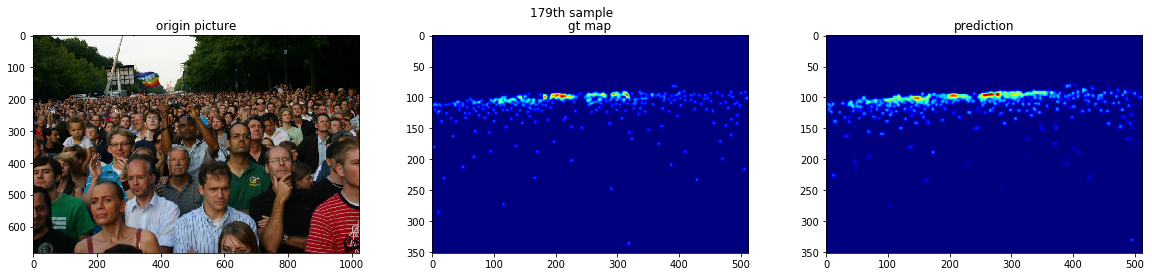

The gt counts of the above sample:400, and the pred counts:372.9472351074219
In step 0, epoch 0, loss = 0.07646972538295421, eval_mae = 61.21162414550781, eval_rmse = 103.42144775390625, time cost eval = 20.884817123413086s


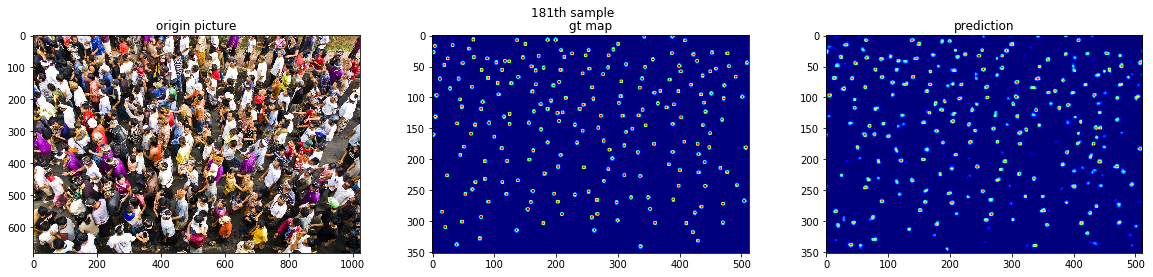

The gt counts of the above sample:216, and the pred counts:185.5730438232422
In step 10, epoch 0, loss = 0.08187280799016172, eval_mae = 65.89790344238281, eval_rmse = 106.41606140136719, time cost eval = 19.972841501235962s


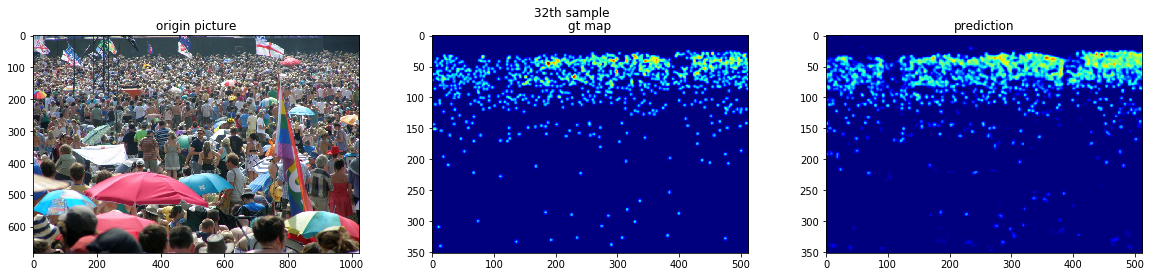

The gt counts of the above sample:961, and the pred counts:959.8616943359375
In step 20, epoch 0, loss = 0.08239400465176451, eval_mae = 67.86234283447266, eval_rmse = 106.41724395751953, time cost eval = 20.10832977294922s


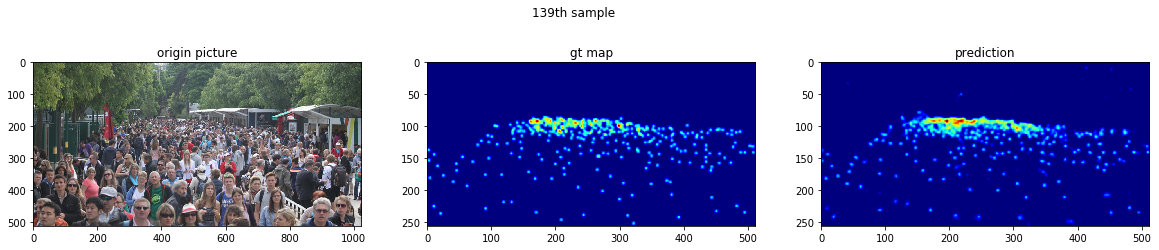

The gt counts of the above sample:355, and the pred counts:336.3084716796875
In step 30, epoch 1, loss = 0.0845809464125458, eval_mae = 69.13069915771484, eval_rmse = 107.89197540283203, time cost eval = 20.142854690551758s


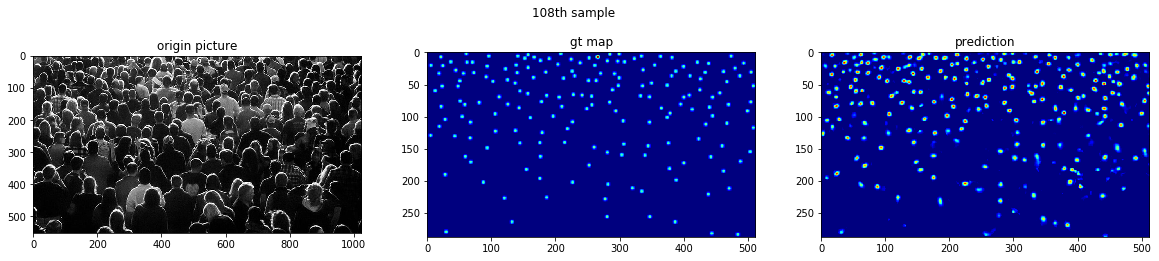

The gt counts of the above sample:182, and the pred counts:186.41358947753906
In step 40, epoch 1, loss = 0.08743291209105832, eval_mae = 68.14466094970703, eval_rmse = 108.60264587402344, time cost eval = 20.09739398956299s


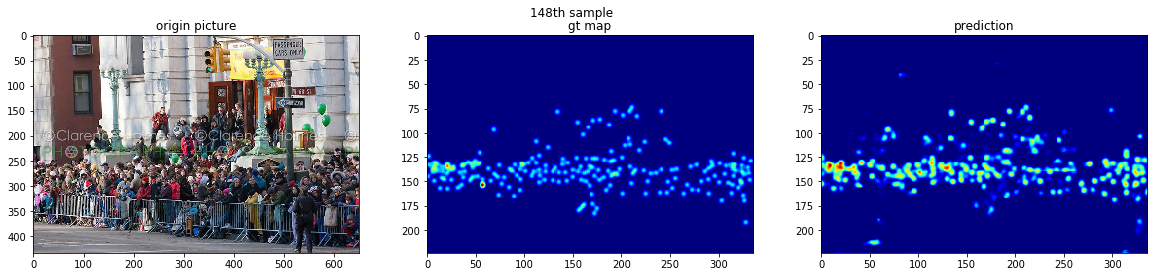

The gt counts of the above sample:208, and the pred counts:182.692626953125
In step 50, epoch 1, loss = 0.08829339008798592, eval_mae = 68.72502899169922, eval_rmse = 108.9637680053711, time cost eval = 20.132909059524536s


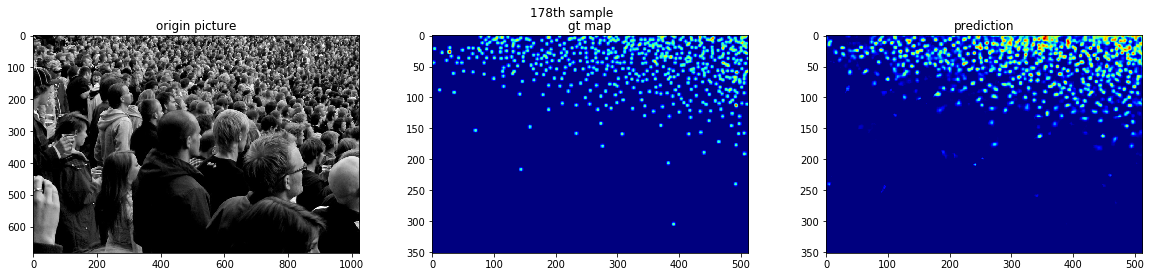

The gt counts of the above sample:549, and the pred counts:477.3691101074219
In step 60, epoch 2, loss = 0.08782647544994576, eval_mae = 68.18611907958984, eval_rmse = 108.69990539550781, time cost eval = 20.185957193374634s


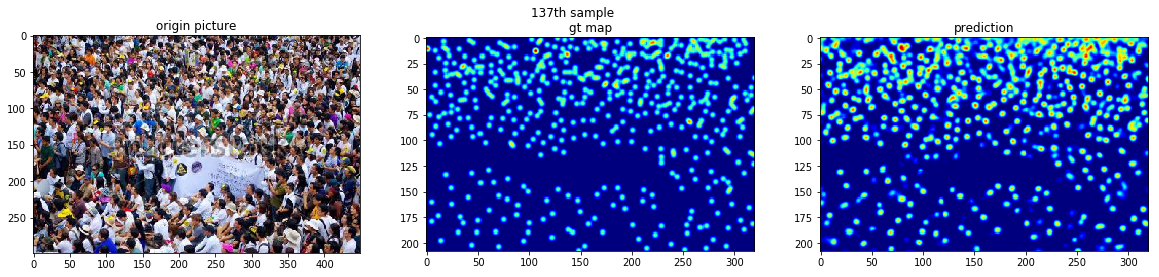

The gt counts of the above sample:491, and the pred counts:457.6338195800781
In step 70, epoch 2, loss = 0.08367932400396293, eval_mae = 66.69577026367188, eval_rmse = 106.46446228027344, time cost eval = 20.026914834976196s


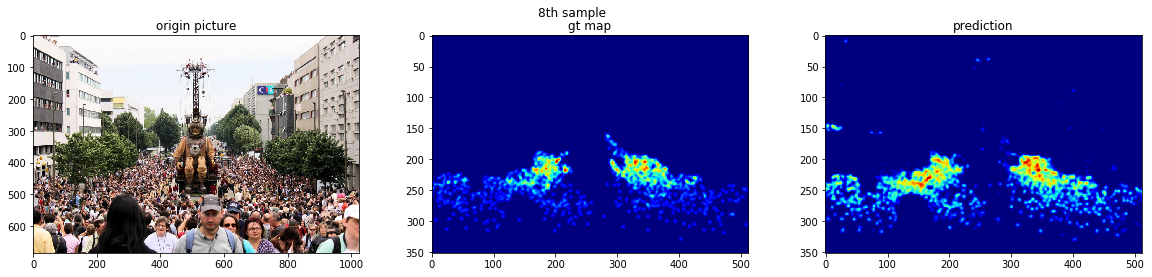

The gt counts of the above sample:1326, and the pred counts:858.374755859375
In step 80, epoch 2, loss = 0.08865933151849896, eval_mae = 69.12271118164062, eval_rmse = 109.66305541992188, time cost eval = 20.073354959487915s


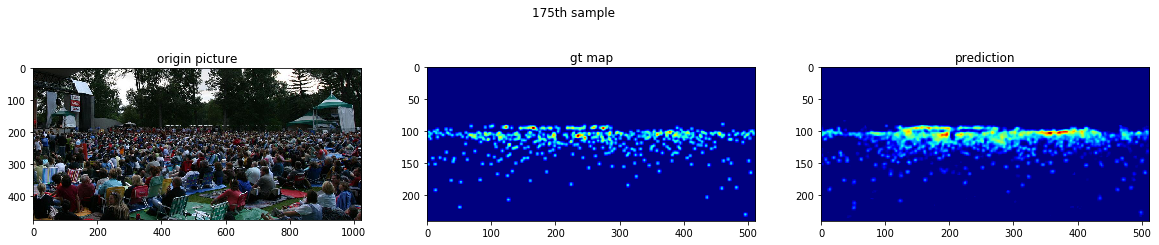

The gt counts of the above sample:442, and the pred counts:677.2870483398438
In step 90, epoch 3, loss = 0.08635896322323958, eval_mae = 69.23075103759766, eval_rmse = 108.80390930175781, time cost eval = 20.021662950515747s


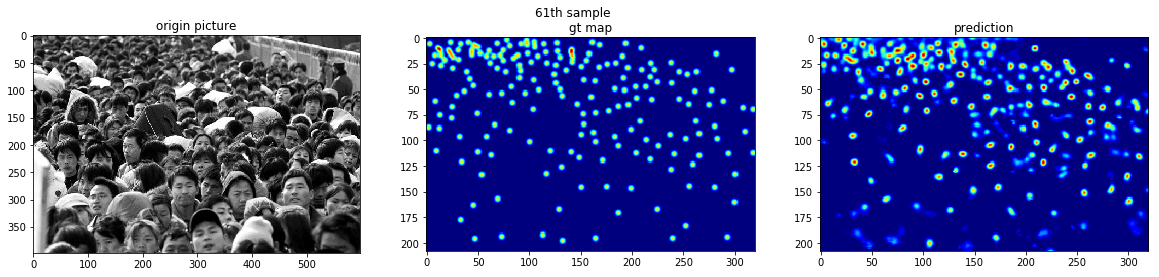

The gt counts of the above sample:193, and the pred counts:157.93194580078125
In step 100, epoch 3, loss = 0.09156290777737562, eval_mae = 68.91902160644531, eval_rmse = 111.32293701171875, time cost eval = 19.986173629760742s


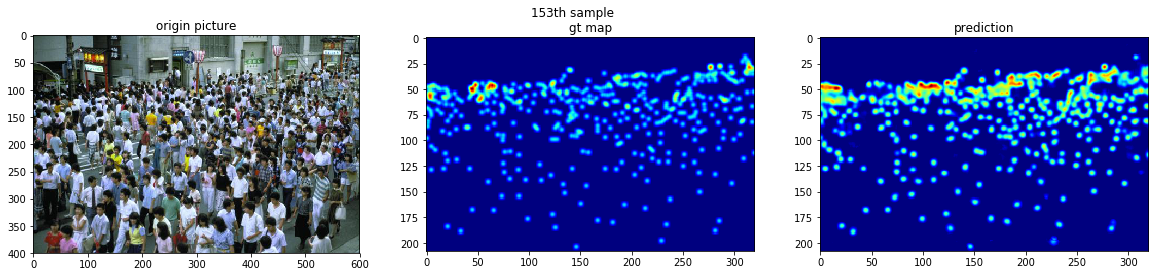

The gt counts of the above sample:397, and the pred counts:362.2662658691406
In step 110, epoch 3, loss = 0.08977910460075263, eval_mae = 68.41458892822266, eval_rmse = 109.73385620117188, time cost eval = 20.09221863746643s


In [ ]:
step = 0
eval_loss = []
eval_mae = []
eval_rmse = []
for epoch_index in range(config['epoch']):
    if epoch_index == 200:
        config['eval_per_step'] == 60
    elif epoch_index == 500:
        config['eval_per_step'] == 30
    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    for train_img_index, train_img, train_gt in train_loader:
        if step % config['eval_per_step'] == 0:
            if_show = True
            validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
                config, eval_loader, modules, if_show)
            eval_loss.append(validate_loss)
            eval_mae.append(validate_MAE)
            eval_rmse.append(eval_rmse)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            #             save model
            if config['stage'] == 'numeration' and config[
                    'min_mae'] > validate_MAE:
                config['min_mae'] = validate_MAE
                torch.save(net.state_dict(), config['model_save_path'])

        net.train()
        torch.cuda.empty_cache()
        x = train_img
        y = train_gt
        start = time.time()
        prediction = net(x)
        loss = criterion(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.data.item())
        optimizer.step()

        step += 1
        torch.cuda.synchronize()
        end = time.time()
        time_per_epoch += end - start

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eval_loss, label='eval_loss')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eval_loss, label='eval_loss')
plt.plot(eval_mae, label='eval_mae')
plt.plot(eval_rmse, label='eval_rmse')
plt.show()

# do not forget the plots

In [ ]:
step = 0
for epoch_index in range(config['epoch']):

    if epoch_index == 100:
        config['stage'] = 'numeration'
        optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
        criterion = torch.nn.MSELoss(reduction='sum').cuda()
        modules['criterion'] = criterion
        net.load_state_dict(torch.load(config['model_save_path']))

    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    for train_img_index, train_img, train_gt in train_loader:
        if step % config['eval_per_step'] == 0:
            if_show = False
            validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
                config, eval_loader, modules, if_show)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            #             save model
            if config[
                    'stage'] == 'shape' and config['min_loss'] > validate_loss:
                config['min_loss'] = validate_loss
                torch.save(net.state_dict(), config['model_save_path'])
            elif config['stage'] == 'numeration' and config[
                    'min_mae'] > validate_MAE:
                config['min_mae'] = validate_MAE
                torch.save(net.state_dict(), config['model_save_path'])

        net.train()
        torch.cuda.empty_cache()
        x = train_img
        if config['stage'] == 'shape':
            train_gt = (train_gt > 0.001).float()
        y = train_gt
        start = time.time()
        if config['stage'] == 'shape':
            prediction = net(x).clamp(0, 1)
        else:
            prediction = net(x)
        loss = criterion(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.data.item())
        optimizer.step()

        step += 1
        torch.cuda.synchronize()
        end = time.time()
        time_per_epoch += end - start
    sys.stdout.write('In epoch {}, the loss = {}, time_cost = {}s\n'.format(
        epoch_index, np.mean(loss_list), time_per_epoch))
    sys.stdout.flush()

In [ ]:
step = 0
for epoch_index in range(config['epoch']):

    if epoch_index == 100:
        config['stage'] = 'numeration'
        optimizer = torch.optim.Adam(net.parameters(), config['learning_rate'])
        criterion = torch.nn.MSELoss(reduction='sum').cuda()
        modules['criterion'] = criterion
        net.load_state_dict(torch.load(config['model_save_path']))

    dataset = train_dataset.shuffle()
    loss_list = []
    time_per_epoch = 0
    for train_img_index, train_img, train_gt in train_loader:
        if step % config['eval_per_step'] == 0:
            if_show = False
            validate_MAE, validate_RMSE, validate_loss, time_cost = eval_model(
                config, eval_loader, modules, if_show)
            sys.stdout.write(
                'In step {}, epoch {}, loss = {}, eval_mae = {}, eval_rmse = {}, time cost eval = {}s\n'
                .format(step, epoch_index, validate_loss, validate_MAE,
                        validate_RMSE, time_cost))
            sys.stdout.flush()
            #             save model
            if config[
                    'stage'] == 'shape' and config['min_loss'] > validate_loss:
                config['min_loss'] = validate_loss
                torch.save(net.state_dict(), config['model_save_path'])
            elif config['stage'] == 'numeration' and config[
                    'min_mae'] > validate_MAE:
                config['min_mae'] = validate_MAE
                torch.save(net.state_dict(), config['model_save_path'])

        net.train()
        torch.cuda.empty_cache()
        x = train_img
        if config['stage'] == 'shape':
            train_gt = (train_gt > 0.001).float()
        y = train_gt
        start = time.time()
        if config['stage'] == 'shape':
            prediction = net(x).clamp(0, 1)
        else:
            prediction = net(x)
        loss = criterion(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        loss_list.append(loss.data.item())
        optimizer.step()

        step += 1
        torch.cuda.synchronize()
        end = time.time()
        time_per_epoch += end - start
    sys.stdout.write('In epoch {}, the loss = {}, time_cost = {}s\n'.format(
        epoch_index, np.mean(loss_list), time_per_epoch))
    sys.stdout.flush()